# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [94]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact

In [95]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [8]:
# Import the necessary CSVs to Pandas DataFrames
# YOUR CODE HERE!

# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sf_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [77]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    # YOUR CODE HERE!
    housing_units = sf_data["housing_units"]
    housing_units = housing_units.groupby([sf_data.index]).mean()
    
    housing_units_fig = plt.figure()
    housing_units_plot = housing_units.plot.bar(x='year', ylim=[370000, 385000], title="Average Number of Housing Units Sold per Year")
    plt.close(housing_units_fig)
    
    return pn.pane.Matplotlib(housing_units_fig) 
# Define Panel Visualization Functions

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    # YOUR CODE HERE!
    average_rent_sqr_foot = sf_data["gross_rent"].groupby([sf_data.index]).mean()
    
    gross_rent_fig = plt.figure()
    average_rent_plot = (average_rent_sqr_foot.plot.line(x='year', y='gross_rent', title="Average Goss Rent per Year"))
    plt.close(gross_rent_fig)
    
    return pn.pane.Matplotlib(gross_rent_fig)


def average_sales_price():
    """Average Sales Price Per Year."""
    
    # YOUR CODE HERE!

    average_price_sqr_foot = sf_data["sale_price_sqr_foot"].groupby([sf_data.index]).mean()
    sales_price_fig = plt.figure()
    average_price_plot = (average_price_sqr_foot.plot.line(x='year', y='sale_price_sqr_foot', title="Average Sales Price per Year"))
    plt.close(sales_price_fig)
    
    return pn.pane.Matplotlib(sales_price_fig)

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    # YOUR CODE HERE!
    sf_data_year = sf_data.groupby(['year','neighborhood']).mean().reset_index()
    
    return sf_data_year.hvplot.line(x='year', 
                                          y='sale_price_sqr_foot',
                                          title='Average Prices by Neighborhood',
                                          groupby='neighborhood', 
                                          ylabel='Avg. Sale Price per Square Foot')



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    # YOUR CODE HERE!
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top10_plot = px.bar(top_10_most_expensive,
    x="neighborhood", 
    y="sale_price_sqr_foot", 
    title="Top 10 Most Expensive Neighborhoods in San Francisco", 
    )

    return top10_plot

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    # YOUR CODE HERE!
    sf_data_mer = sf_data.groupby(['neighborhood']).mean().nlargest(10,'sale_price_sqr_foot')
    df_expensive_neighborhoods_per_year = sf_data[sf_data["neighborhood"].isin(sf_data_mer.reset_index()["neighborhood"])]

    return df_expensive_neighborhoods_per_year.hvplot.bar(x='year',
                                         y=['sale_price_sqr_foot','gross_rent'],
                                         title='Most Expensive Neighborhoods in San Francisco',
                                         ylabel='Num. Housing Units',
                                         xlabel='Year',
                                         groupby='neighborhood', 
                                         rot=90, color=['red','blue'],
                                         height=500)

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    # YOUR CODE HERE!
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()    
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel = px.parallel_coordinates(
    top_10_most_expensive, 
    color='sale_price_sqr_foot')

    return top_10_parallel


def parallel_categories():
    """Parallel Categories Plot."""
    
    # YOUR CODE HERE!
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()  
    top_10_ex_neighborhood = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel_categories = px.parallel_categories(
    top_10_ex_neighborhood,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
)

    return top_10_parallel_categories


def neighborhood_map():
    """Neighborhood Map."""

    # YOUR CODE HERE!
    loc_data_filepath = Path("data/neighborhoods_coordinates.csv")
    loc_data = pd.read_csv(loc_data_filepath).set_index('Neighborhood')
    mean_data = sf_data.groupby(['neighborhood']).mean()
    mean_data_loc = pd.concat([mean_data, loc_data], axis='columns', join='inner')

    mapbox_plot = px.scatter_mapbox(
        mean_data_loc,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        zoom = 10)
    
    return mapbox_plot

def sunburst():
    """Sunburst Plot."""
    sf_data_sun = sf_data.groupby(['neighborhood']).mean().nlargest(10,'sale_price_sqr_foot')
    df_expensive_neighborhoods_per_year = sf_data[sf_data["neighborhood"].isin(sf_data_sun.reset_index()["neighborhood"])]

    sunburst_plot = px.sunburst(
        df_expensive_neighborhoods_per_year.reset_index(),
        path=['year','neighborhood'], 
        values='sale_price_sqr_foot')
    
    return sunburst_plot
    # YOUR CODE HERE!


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [78]:
# Create a Title for the Dashboard
# YOUR CODE HERE!
title = '#Real Estate Analysis of San Francisco from 2010-2016'
welcome_tab = pn.Row(pn.Column(title), neighborhood_map())

market_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())


neighborhood_analysis_tab = pn.Column(interact(average_price_by_neighborhood, neighborhood=neighborhood_choice),
    top_most_expensive_neighborhoods()
)

parallel_plots_tab = pn.Column( 
    parallel_categories(),
    parallel_coordinates()
)


# Create a tab layout for the dashboard
# YOUR CODE HERE!

SF_dashboard = pn.Tabs(("Welcome", welcome_tab), 
("Yearly Market Analysis", market_analysis_row),
("Neighborhood Analysis", neighborhood_analysis_tab), 
("Interactive Market Analysis by Neighborhood", parallel_plots_tab))

# Create the dashboard
# YOUR CODE HERE!

## Serve the Panel Dashboard

Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Column
            [0] Column()
            [1] Row
                [0] Row(name='interactive05221')
                    [0] HoloViews(DynamicMap, name='interactive05221')
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                        [1] VSpacer()
        [1] Plotly(Figure, visible=False)
    [3] Column
        [0] Plotly(Figure, visible=False)
        [1] Plotly(Figure, visible=False)
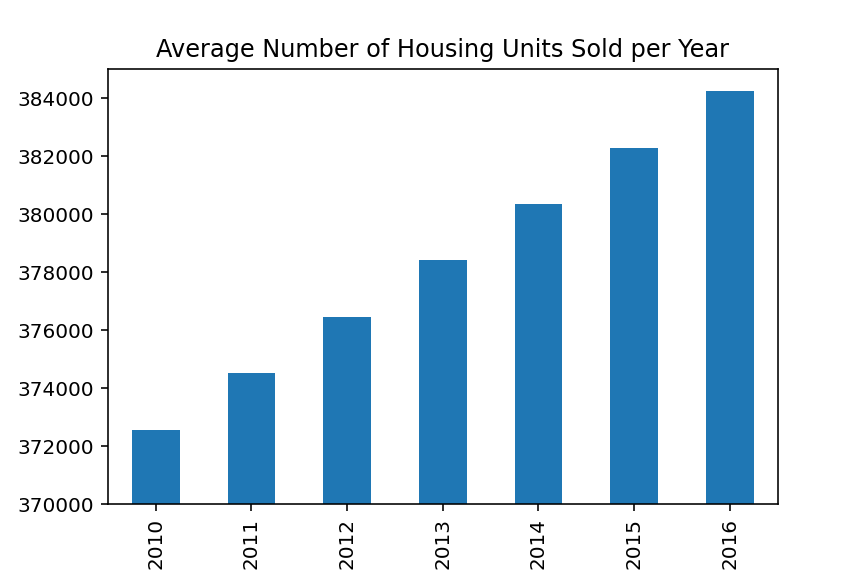
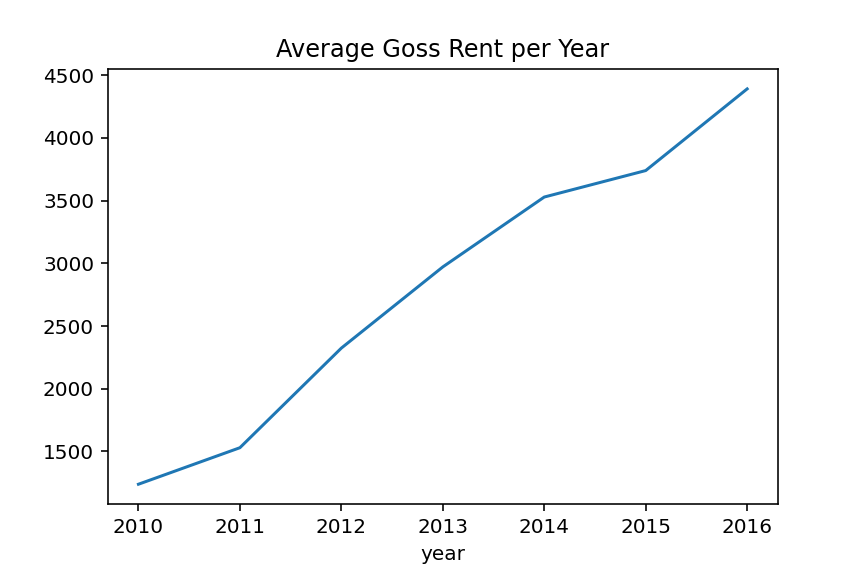
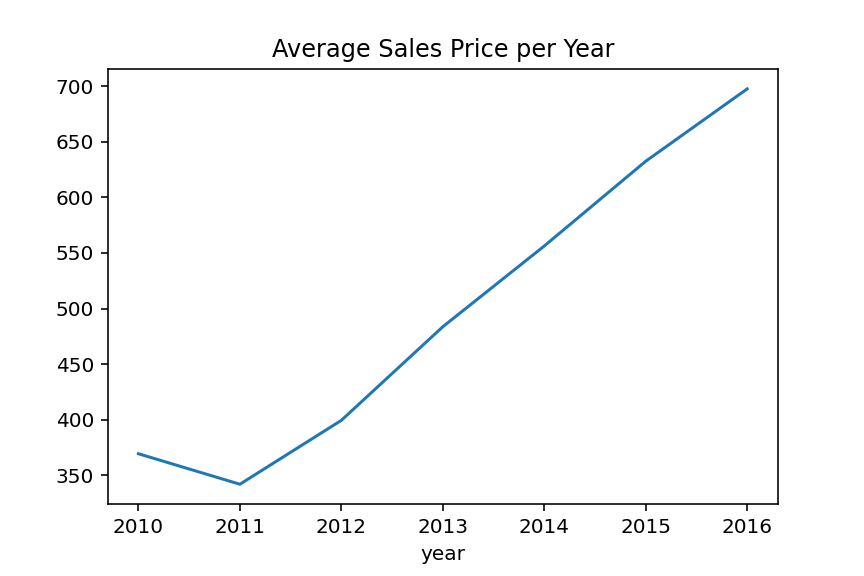

In [79]:
# Serve the# dashboard
# YOUR CODE HERE!
SF_dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure)
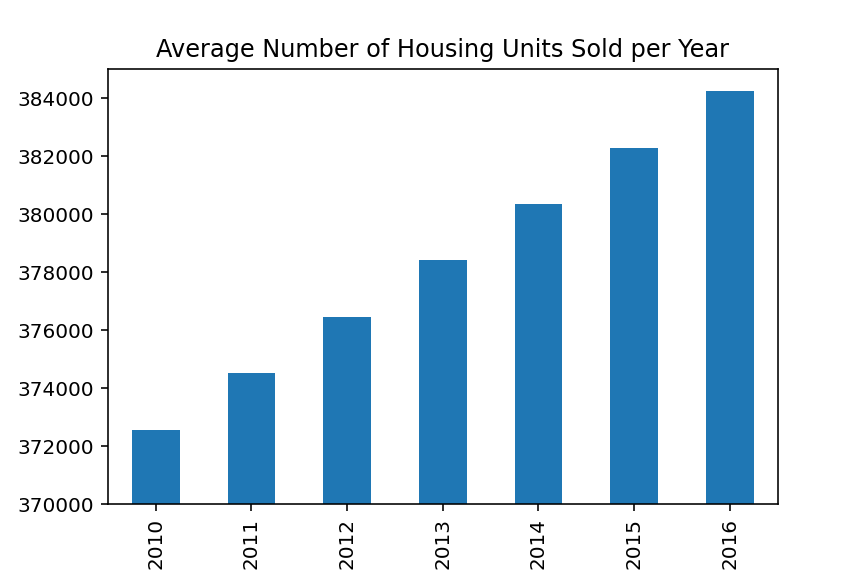

In [80]:
# housing_units_per_year()

housing_units_per_year()

Matplotlib(Figure)
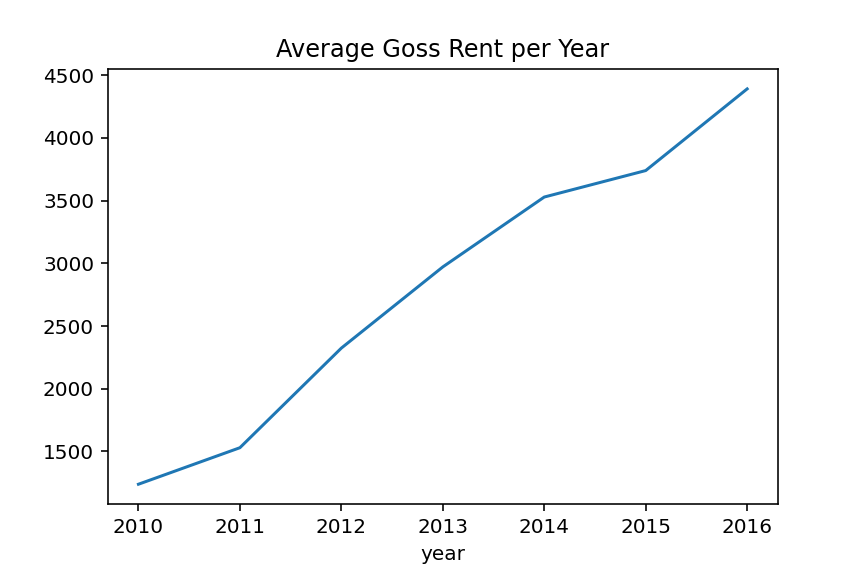

In [81]:
# average_gross_rent()
average_gross_rent()

Matplotlib(Figure)
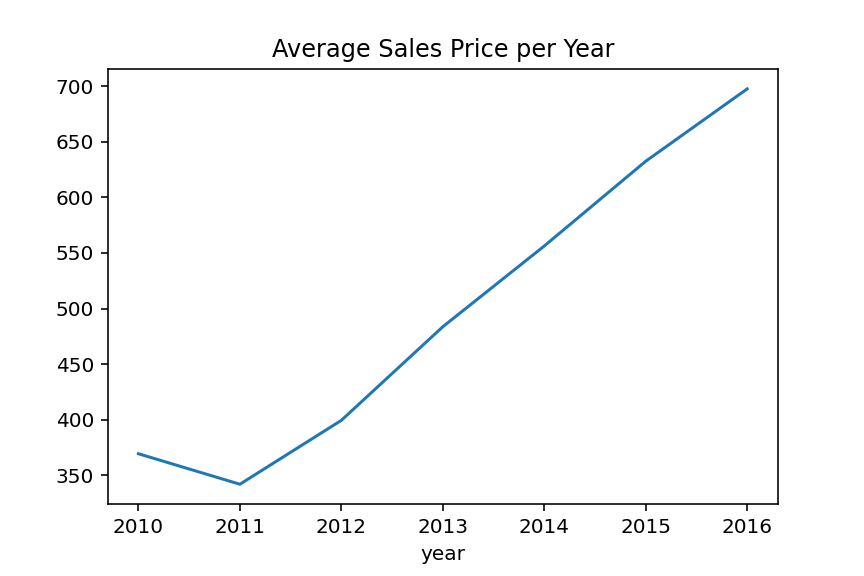

In [82]:
# average_sales_price()
average_sales_price()

In [83]:
# average_price_by_neighborhood()
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

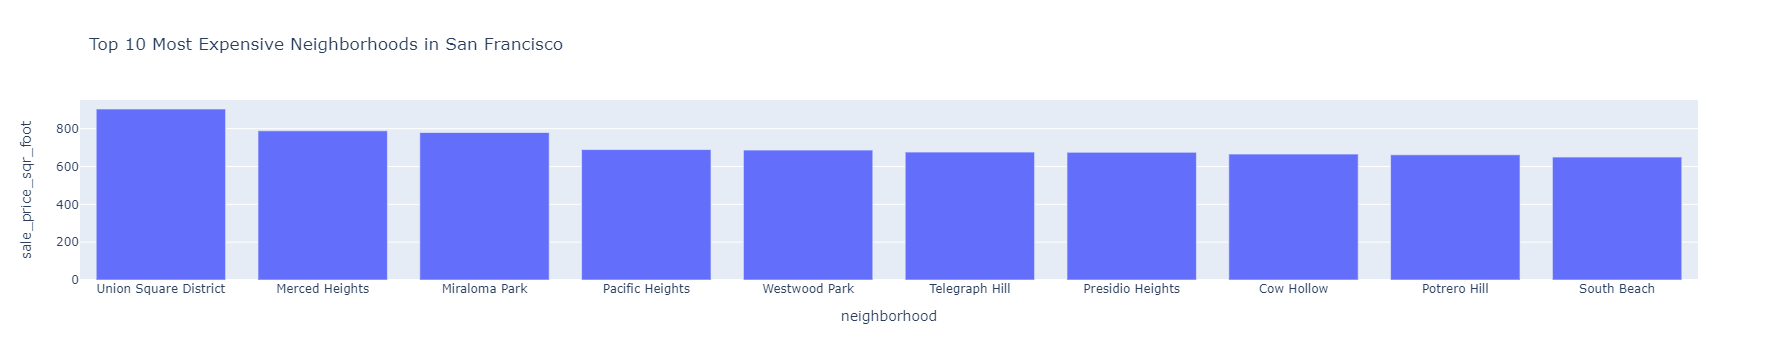

In [84]:
# top_most_expensive_neighborhoods()
top_most_expensive_neighborhoods()

In [85]:
# most_expensive_neighborhoods_rent_sales()
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [90]:
# neighborhood_map().show()
neighborhood_map().show()

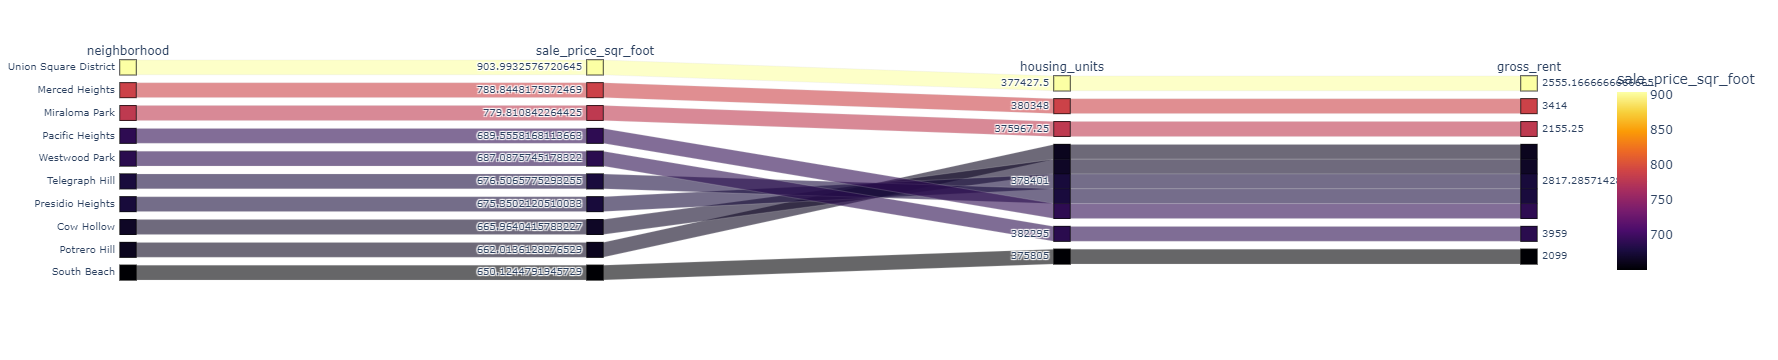

In [91]:
# parallel_categories()
parallel_categories()

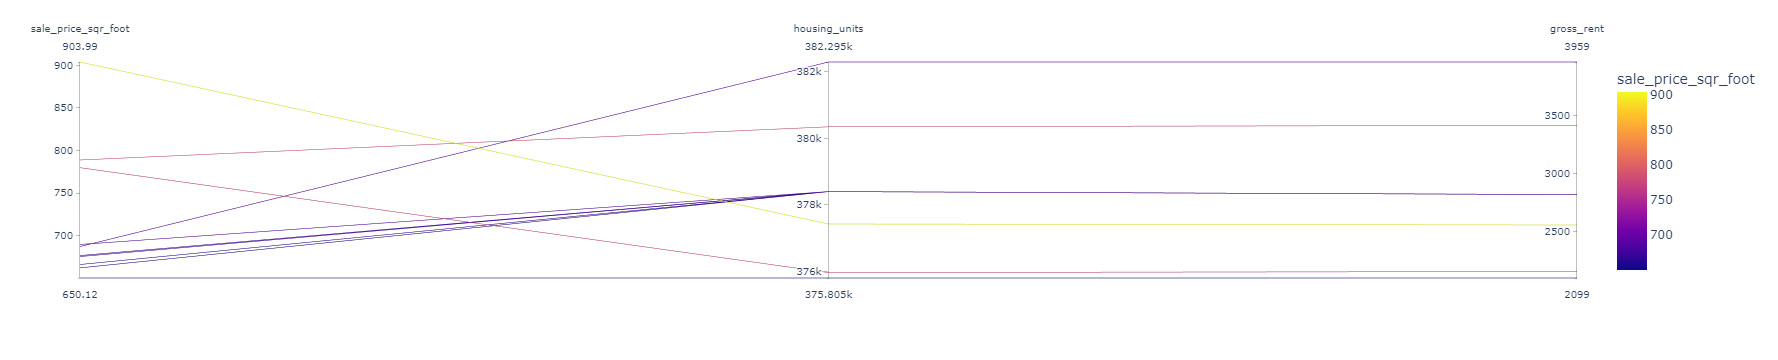

In [92]:
# parallel_coordinates()
parallel_coordinates()

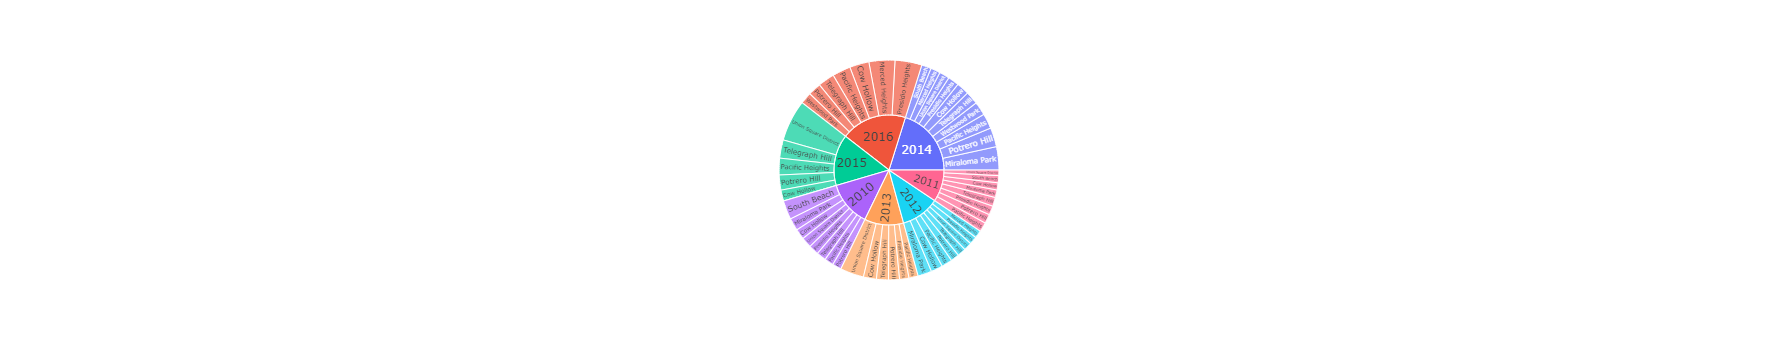

In [93]:
# sunburst()
sunburst()